In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import gcsfs
from time import time
from shapely.vectorized import contains
import numpy as np

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
comid = 4512772 # some small segment on the Potomac near DC
sp_idx_fp = 'data/nwm-v1.2-channel_spatial_index.nc'

In [3]:
# fs = gcsfs.GCSFileSystem(project='floodcast')
# d = fs.open('fcast/datastore/NWM/nwm-v1.2-channel_spatial_index.nc')
# ds = xr.open_dataset(d)

# Open the spatial index file

In [6]:
ds = xr.open_dataset(sp_idx_fp)
pt = Point(float(ds.sel(feature_id=comid)['longitude']), float(ds.sel(feature_id=comid)['latitude']))
# pt

In [8]:
# Make it a dataframe
df = ds.to_dataframe()
df.head()

,latitude,longitude
feature_id,,
101,31.086876,-94.640541
179,46.022163,-67.986412
181,46.016491,-67.998726
183,46.020847,-67.998833
185,46.019714,-67.998619


# Give each point a state fips code

In [9]:
# a shapefile of states, to identify which points are in which state. Spatial reduction method
stateshp = r'C:\Data\Boundaries\cb_2017_us_state_500k\cb_2017_us_state_500k.shp'
usgdf = gpd.read_file(stateshp)
usgdf = usgdf.copy().to_crs(ds.proj4)

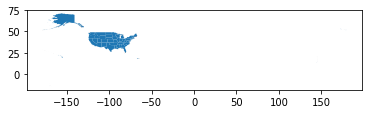

In [10]:
usgdf.plot()

In [11]:
x = df['longitude'].to_numpy()
y = df['latitude'].to_numpy()
print(f'length of x: {len(x)}, length of y: {len(y)}')
assert len(x) == len(y), 'Error: there are x or y points missing'

length of x: 2729077, length of y: 2729077


In [12]:
start = time()

for i, g in enumerate(usgdf.geometry.tolist()):
    bmask = contains(g, x, y)
    geoid = usgdf.iloc[i]['GEOID']
    df['bool'] = bmask
    df.loc[df['bool'] == True, 'ST'] = geoid

print('Proccessing time = {} minutes'.format(round((time()-start)/60,2)))

Proccessing time = 1.13 minutes


In [13]:
df = df.drop('bool', axis=1)
df.head()

,latitude,longitude,ST
feature_id,,,
101,31.086876,-94.640541,48
179,46.022163,-67.986412,23
181,46.016491,-67.998726,23
183,46.020847,-67.998833,23
185,46.019714,-67.998619,23


# Give each point a county fips code

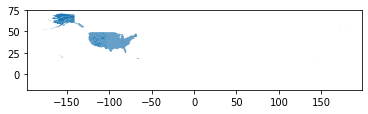

In [14]:
countyshp = r"C:\Data\Boundaries\cb_2017_us_county_500k\cb_2017_us_county_500k.shp"
county_gdf = gpd.read_file(countyshp)
county_gdf = county_gdf.copy().to_crs(ds.proj4)
county_gdf.plot()

In [15]:
county_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720 31.26436, -87.42551 31.268..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333 32.75059, -86.37115 32.750..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.87046 32.76244, -87.86818 32.765..."


In [16]:
start = time()

for i, g in enumerate(county_gdf.geometry.tolist()):
    bmask = contains(g, x, y)
    geoid = county_gdf.iloc[i]['GEOID']
    df['bool'] = bmask
    df.loc[df['bool'] == True, 'CNTY'] = geoid

print('Proccessing time = {} minutes'.format(round((time()-start)/60,2)))

Proccessing time = 62.12 minutes


In [17]:
df = df.drop('bool', axis=1)
df.head()

,latitude,longitude,ST,CNTY
feature_id,,,,
101,31.086876,-94.640541,48,48373
179,46.022163,-67.986412,23,23003
181,46.016491,-67.998726,23,23003
183,46.020847,-67.998833,23,23003
185,46.019714,-67.998619,23,23003


## Save half way

In [18]:
df.to_csv('data/nwm_lookup_table_intermediate.csv')

# Give each point some well-known-text

In [19]:
gdf = gpd.GeoDataFrame(df, geometry=[Point(c) for c in list(zip(df.longitude, df.latitude))])
gdf.crs = ds.proj4
gdf.head()

,latitude,longitude,ST,CNTY,geometry
feature_id,,,,,
101,31.086876,-94.640541,48,48373,POINT (-94.64054 31.08688)
179,46.022163,-67.986412,23,23003,POINT (-67.98641 46.02216)
181,46.016491,-67.998726,23,23003,POINT (-67.99873 46.01649)
183,46.020847,-67.998833,23,23003,POINT (-67.99883 46.02085)
185,46.019714,-67.998619,23,23003,POINT (-67.99862 46.01971)


In [20]:
gdf['pt_wkt'] = gdf.geometry.apply(lambda x: x.to_wkt())
gdf.head()

,latitude,longitude,ST,CNTY,geometry,pt_wkt
feature_id,,,,,,
101,31.086876,-94.640541,48,48373,POINT (-94.64054 31.08688),POINT (-94.6405410766601563 31.0868759155273438)
179,46.022163,-67.986412,23,23003,POINT (-67.98641 46.02216),POINT (-67.9864120483398438 46.0221633911132813)
181,46.016491,-67.998726,23,23003,POINT (-67.99873 46.01649),POINT (-67.9987258911132813 46.0164909362792969)
183,46.020847,-67.998833,23,23003,POINT (-67.99883 46.02085),POINT (-67.9988327026367188 46.0208473205566406)
185,46.019714,-67.998619,23,23003,POINT (-67.99862 46.01971),POINT (-67.9986190795898438 46.0197143554687500)


In [23]:
out_df = pd.DataFrame(gdf.drop('geometry', axis=1))
out_df.head()

,latitude,longitude,ST,CNTY,pt_wkt
feature_id,,,,,
101,31.086876,-94.640541,48,48373,POINT (-94.6405410766601563 31.0868759155273438)
179,46.022163,-67.986412,23,23003,POINT (-67.9864120483398438 46.0221633911132813)
181,46.016491,-67.998726,23,23003,POINT (-67.9987258911132813 46.0164909362792969)
183,46.020847,-67.998833,23,23003,POINT (-67.9988327026367188 46.0208473205566406)
185,46.019714,-67.998619,23,23003,POINT (-67.9986190795898438 46.0197143554687500)


## Overwrite the half way save file

In [24]:
out_df.to_csv('data/nwm_lookup_table_intermediate.csv')

# Why are there nan values..?

In [58]:
test_out_df = out_df.fillna(9999)

In [60]:
count = 0
for i, f in enumerate(test_out_df.ST):
    if not type(f) == str:
        count +=1
count

63004

In [61]:
coastals = test_out_df.loc[test_out_df.ST == 9999]

In [62]:
coastals_gdf = gpd.GeoDataFrame(coastals, geometry=[Point(c) for c in list(zip(coastals.longitude, coastals.latitude))])
coastals_gdf.crs = ds.proj4

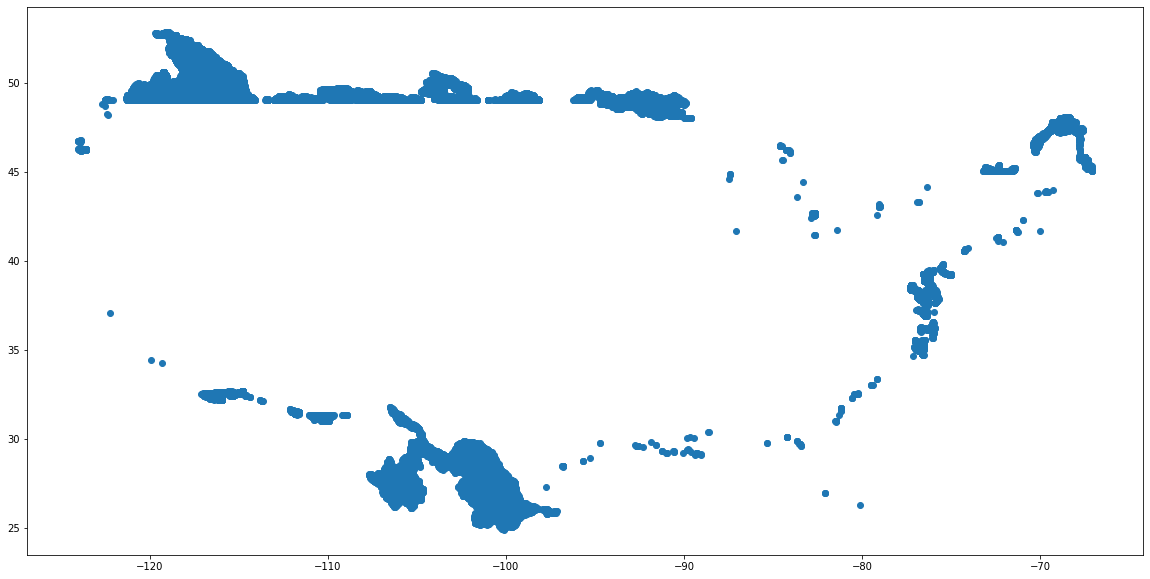

In [65]:
coastals_gdf.plot(figsize=(20,20))

In [68]:
coastals_gdf.reset_index().to_file('data/not_conus_pts.shp')

In [79]:
for i, file in enumerate(['data/mexico.shp', 'data/canada.shp', 'data/coastal.shp']):
    if i == 0:
        code = file.split('.')[0].split('/')[1].upper()
        print(code)
        geodf = gpd.read_file(file)
        geodf['ST'] = code
        geodf['CNTY'] = code
    else:
        code = file.split('.')[0].split('/')[1].upper()
        print(code)
        geodf1 = gpd.read_file(file)
        geodf1['ST'] = code
        geodf1['CNTY'] = code
        geodf = geodf.append(geodf1)

MEXICO
CANADA
COASTAL


In [81]:
geodf = geodf.set_index('feature_id', drop=True).drop('geometry', axis=1)

In [82]:
geodf.head()

,latitude,longitude,ST,CNTY,pt_wkt
feature_id,,,,,
1130001096,28.565666,-101.584686,MEXICO,MEXICO,POINT (-101.5846862792968750 28.5656661987304688)
1130001099,28.560751,-101.929932,MEXICO,MEXICO,POINT (-101.9299316406250000 28.5607509613037109)
1130001098,28.575823,-101.525703,MEXICO,MEXICO,POINT (-101.5257034301757813 28.5758228302001953)
1130001101,28.211279,-106.131920,MEXICO,MEXICO,POINT (-106.1319198608398438 28.2112789154052734)
1130001100,28.553598,-101.923080,MEXICO,MEXICO,POINT (-101.9230804443359375 28.5535984039306641)


In [86]:
forappending = test_out_df.loc[test_out_df.ST != 9999]

In [87]:
forappending.shape

(2666073, 5)

In [89]:
final_output = forappending.append(geodf)

In [91]:
final_output.shape

(2729077, 5)

In [96]:
for x in final_output.CNTY.unique():
    assert type(x) == str 

In [97]:
final_output.to_csv('data/nwm-v1.2-channel_spatial_index_w_attrs.csv')

# Convert it back to a net cdf with the additional data

In [98]:
final_nc_ds = xr.Dataset.from_dataframe(final_output)

In [99]:
final_nc_ds.attrs = ds.attrs
final_nc_ds

<xarray.Dataset>
Dimensions:     (feature_id: 2729077)
Coordinates:
  * feature_id  (feature_id) int64 101 179 181 ... 932040360 947080027 948060094
Data variables:
    latitude    (feature_id) float64 31.09 46.02 46.02 ... 39.69 46.24 34.43
    longitude   (feature_id) float64 -94.64 -67.99 -68.0 ... -123.6 -119.9
    ST          (feature_id) object '48' '23' '23' ... 'COASTAL' 'COASTAL'
    CNTY        (feature_id) object '48373' '23003' ... 'COASTAL' 'COASTAL'
    pt_wkt      (feature_id) object 'POINT (-94.6405410766601563 31.0868759155273438)' ... 'POINT (-119.9183044433593750 34.4312324523925781)'
Attributes:
    proj4:                +proj=longlat +datum=NAD83 +no_defs
    esri_pe_string:       GEOGCS[GCS_North_American_1983,DATUM[D_North_Americ...
    model_version:        NWM 1.2
    Conventions:          CF-1.6
    cdm_datatype:         Station
    station_dimension:    feature_id
    stream_order_output:  1

In [100]:
final_nc_ds.to_netcdf('data/nwm-v1.2-channel_spatial_index_w_attrs.nc')

In [101]:
fs = gcsfs.GCSFileSystem(project='floodcast')
d = fs.open('fcast/datastore/NWM/nwm-v1.2-channel_spatial_index_w_attrs.nc')
ds = xr.open_dataset(d)
ds

<xarray.Dataset>
Dimensions:     (feature_id: 2729077)
Coordinates:
  * feature_id  (feature_id) int64 101 179 181 ... 932040360 947080027 948060094
Data variables:
    latitude    (feature_id) float64 ...
    longitude   (feature_id) float64 ...
    ST          (feature_id) object ...
    CNTY        (feature_id) object ...
    pt_wkt      (feature_id) object ...
Attributes:
    proj4:                +proj=longlat +datum=NAD83 +no_defs
    esri_pe_string:       GEOGCS[GCS_North_American_1983,DATUM[D_North_Americ...
    model_version:        NWM 1.2
    Conventions:          CF-1.6
    cdm_datatype:         Station
    station_dimension:    feature_id
    stream_order_output:  [1]